# Training

In [1]:
import os
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf

pd.options.display.max_columns = None
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # to avoid too many logs from tensorflow-metal

In [2]:
DATA_PATH = "../../data/"
MODELS_PATH = "../../models/"

MODEL_CONFIGS = {
    "ResNet50": {
        "model": tf.keras.applications.resnet50.ResNet50,
        "preprocessing": tf.keras.applications.resnet50.preprocess_input,
    },
    "ResNet50V2": {
        "model": tf.keras.applications.resnet_v2.ResNet50V2,
        "preprocessing": tf.keras.applications.resnet_v2.preprocess_input,
    },
    "MobileNetV3Small": {
        "model": tf.keras.applications.MobileNetV3Small,
        "preprocessing": tf.keras.applications.mobilenet_v3.preprocess_input,
    },
    "EfficientNetV2B0": {
        "model": tf.keras.applications.efficientnet_v2.EfficientNetV2B0,
        "preprocessing": tf.keras.applications.efficientnet_v2.preprocess_input,
    },
    "EfficientNetV2S":  {
        "model": tf.keras.applications.efficientnet_v2.EfficientNetV2S,
        "preprocessing": tf.keras.applications.efficientnet_v2.preprocess_input,
    },
    "EfficientNetV2M": {
        "model": tf.keras.applications.efficientnet_v2.EfficientNetV2M,
        "preprocessing": tf.keras.applications.efficientnet_v2.preprocess_input,
    },
}

In [3]:
def build_generators(model_type, image_size, batch_size, augmentation_level):
    
    # Data Augmentation levels
    if augmentation_level == "None":
        train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=MODEL_CONFIGS[model_type]["preprocessing"],
        )
    elif augmentation_level == "Low":
        train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=MODEL_CONFIGS[model_type]["preprocessing"],
            horizontal_flip=True,
            brightness_range=(0.7, 1),
            zoom_range=[0.7, 1],
        )
    elif augmentation_level == "Medium":
        train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=MODEL_CONFIGS[model_type]["preprocessing"],
            horizontal_flip=True,
            brightness_range=(0.5, 1.2),
            zoom_range=[0.7, 1],
            rotation_range=20,
            shear_range=0.2,
            width_shift_range=0.2,
            height_shift_range=0.2
        )
    elif augmentation_level == "High":
        train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=MODEL_CONFIGS[model_type]["preprocessing"],
            horizontal_flip=True,
            brightness_range=(0.5, 1.2),
            zoom_range=[0.5, 1.2],
            rotation_range=30,
            shear_range=0.3,
            width_shift_range=0.2,
            height_shift_range=0.2
        )
    else:
        raise Exception(f"{augmentation_level} is not a valid argument for augmentation_level")
    
    # No data augmentation on validation and test datasets
    valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=MODEL_CONFIGS[model_type]["preprocessing"],
    )
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=MODEL_CONFIGS[model_type]["preprocessing"],
    )
    
    # Data Generators
    train_generator = train_datagen.flow_from_directory(
        DATA_PATH + "train",
        target_size=image_size,
        batch_size=batch_size,
        class_mode="categorical",
    )
    valid_generator = valid_datagen.flow_from_directory(
        DATA_PATH + "valid",
        target_size=image_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False,
    )
    test_generator = test_datagen.flow_from_directory(
        DATA_PATH + "test",
        target_size=image_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False,
    )

    labels = list(train_generator.class_indices.keys())
    
    return labels, train_generator, valid_generator, test_generator

In [4]:
def build_model(
    model_type,
    n_classes,
    learning_rate,
    image_size,
    dense=False,
    dropout=False,
    ):
    if model_type not in MODEL_CONFIGS.keys():
        raise Exception(f"{model_type} is not a valid argument for model_type")

    base_model = MODEL_CONFIGS[model_type]["model"](
        weights="imagenet", 
        input_shape=(*(image_size), 3), 
        include_top=False, 
        pooling="avg"
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(*(image_size), 3))
    x = base_model(inputs, training=False)
    if dropout:
        x = tf.keras.layers.Dropout(dropout)(x)
    if dense:
        x = tf.keras.layers.Dense(dense, activation="relu")(x)
        if dropout:
            x = tf.keras.layers.Dropout(dropout)(x)
    outputs = tf.keras.layers.Dense(n_classes, activation="softmax")(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate),
        loss="categorical_crossentropy", 
        metrics=["accuracy"]
    )
    return model

In [5]:
def train_model(model, model_idx, train_generator, valid_generator, epochs):

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        min_delta=0.001,
        patience=3,
        restore_best_weights=True,
    )

    history = model.fit(
        train_generator, 
        validation_data=valid_generator, 
        epochs=epochs, 
        callbacks=[early_stopping],
    )
    
    return history

In [6]:
def plot_training(history, params):

    plot_path = MODELS_PATH + "plots/"
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))

    # Accuracy
    axs[0].plot(history.history['accuracy'], 'b', label='Training')
    axs[0].plot(history.history['val_accuracy'], 'r', linestyle="--", label='Validation')
    axs[0].set_title('Accuracy')
    axs[0].legend()

    # Loss
    axs[1].plot(history.history['loss'], 'b', label='Training')
    axs[1].plot(history.history['val_loss'], 'r', linestyle="--", label='Validation')
    axs[1].set_title('Loss')
    axs[1].legend()

    plt.suptitle("Model " + " - ".join([str(p) for p in params]), y=0.99, fontsize=10)
    plt.savefig(plot_path + "model_" + str(params[0]) + ".png")

In [7]:
parameters = [
    "Image Size", 
    "Batch Size", 
    "Augmentation Level",
    "Model Type",
    "Parameters",
    "Learning Rate", 
    "Dense Layer", 
    "Dropout Layer", 
    "Max Epochs", 
    "Best Epoch",
    "Running Time",
    "Accuracy",
]

def log_training(params):
    logs_path = MODELS_PATH + "results.json"
    if os.path.exists(logs_path):
        results = pd.read_json(logs_path, orient="index")
    else:
        results = pd.DataFrame(columns=parameters)
    results.loc[params[0]] = params[1:]
    results.to_json(logs_path, orient="index")

In [8]:
def test_model(
    image_size=(256, 256), 
    batch_size=64, 
    augmentation="None",
    model_type="ResNet50",
    learning_rate=0.001, 
    dense=False, 
    dropout=False, 
    epochs=20
    ):

    # Define a model index
    model_idx = 0
    while os.path.exists(f"{MODELS_PATH}model_{model_idx}.h5"):
        model_idx += 1

    # Build data generators
    labels, train_generator, valid_generator, test_generator = build_generators(
        model_type, image_size, batch_size, augmentation
    )
    
    # Build model
    model = build_model(
        model_type=model_type,
        n_classes=len(labels), 
        learning_rate=learning_rate, 
        image_size=image_size, 
        dense=dense, 
        dropout=dropout
    )
    model.summary()
    model_params = f"{round(model.count_params() / 1000000, 1)}M"

    # Train
    start = time.time()
    history = train_model(model, model_idx, train_generator, valid_generator, epochs)
    end = time.time()
    runtime = (end - start) // 60
    num_epochs = len(history.history["val_accuracy"])

    # Test
    proba = model.predict(test_generator)
    predictions = np.argmax(proba, axis=1)
    accuracy = np.mean(test_generator.classes == predictions)
    print(f"Accuracy: {round(100 * accuracy, 1)}%")

    # Save training plot and training logs
    params = [
        model_idx,
        image_size, 
        batch_size, 
        augmentation, 
        model_type, 
        model_params,
        learning_rate, 
        dense, 
        dropout, 
        epochs, 
        num_epochs,
        runtime, 
        accuracy
    ]
    plot_training(history, params)
    log_training(params)

    # Save model
    model.save(f"{MODELS_PATH}model_{model_idx}.h5")

    return model

## Training

Found 83242 images belonging to 30 classes.
Found 7607 images belonging to 30 classes.
Found 7602 images belonging to 30 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 1280)              5919312   
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 30)                38430     
                                                                 
Total params: 5957742 (22.73 MB)
Trainable params: 38430 (150.12 KB)
Non-trainable params: 5919312 (22.58 MB)
___________________

/Users/louisguichard/anaconda3/envs/pictify_env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


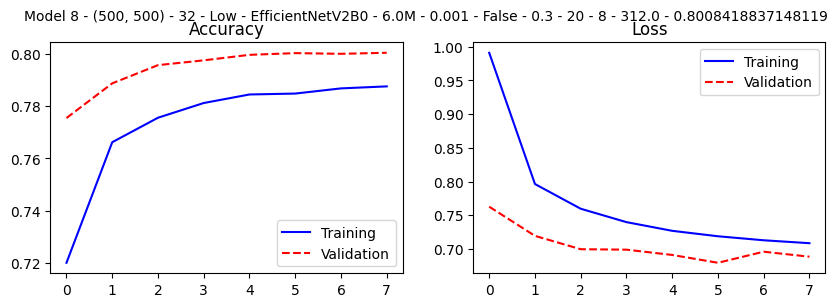

In [9]:
# Data
image_size = (500, 500) 
batch_size = 32
augmentation = "Low"

# Model
model_type = "EfficientNetV2B0"
learning_rate = 0.001
dense = False
dropout = 0.3
epochs = 20

model = test_model(
    image_size, batch_size, augmentation, 
    model_type, learning_rate, dense, dropout, epochs
)